# Pretrained Model for Movie Genre Classification

## 1) Introduction
In this section i will use **transfer learning** on a pretrained model to classify the posters. I also will compare it to my custom CNN.

## 3) Hyperparameter Choices

| Parameter        | Value  | Reason  |
|-----------------|--------|---------|
| Pretrained model      | ResNet | ResNet is quite fast and efficient my laptop has not mutch power so this is ideal |
| Dataset size      | 200 images | Otherwise training takes about two hours |
| Activation      | ReLU (hidden layers), Sigmoid (output) | Relu for efficiency and Sigmoid for multi-label probability predictions / classifications |
| Optimizer       | Adam   | Adaptive learning rate for better convergence |
| Loss Function   | Binary Crossentropy | Multi-label classification requires independent class probabilities |
| Batch Size      | 32-64     | Balances training speed and memory usage |
| Dropout Rate    | 0.5    | Helps prevent overfitting |



## 4) Loading in dataset.

In [41]:
import pandas as pd

dataset = pd.read_excel('./data/data.xlsx')
dataset = dataset.head(200)
dataset.head()

,imdbID,Genre
0,tt0080684,"Action, Adventure, Fantasy"
1,tt0081562,"Comedy, Crime"
2,tt0080339,Comedy
3,tt0080377,"Action, Comedy"
4,tt0081375,"Comedy, War"


Before we can use the Genre we need to one hot encode them so they can be used by the Network

In [42]:
clean_genres = dataset['Genre'].str.replace(', ', ',').str.replace(' ,', ',')
Y = clean_genres.str.get_dummies(sep=',')
Y.head()

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [43]:
dataset = pd.concat([dataset, Y], axis=1)
dataset

,imdbID,Genre,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,tt0080684,"Action, Adventure, Fantasy",1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,tt0081562,"Comedy, Crime",0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,tt0080339,Comedy,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0080377,"Action, Comedy",1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,tt0081375,"Comedy, War",0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,tt0086006,"Action, Adventure, Thriller",1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
196,tt0085750,Horror,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
197,tt0085255,"Action, Crime, Drama",1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
198,tt0086619,"Drama, Musical, Romance",0,0,0,0,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0


We first load all images, preprocess them, and split them into training, validation, and test sets.


In [13]:
import cv2
import numpy as np


# Function to load and normalize images
def preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0
    return img


In [44]:
import os

images_folder = './data/processed'
classnames = Y.columns.tolist()

X_images, y_labels = [], []
for index, row in dataset.iterrows():
    img_name = f"{row['imdbID']}.jpg"
    img_path = os.path.join(images_folder, img_name)
    if os.path.exists(img_path):
        processed_image = preprocess_image(img_path)
        if processed_image is not None:
            X_images.append(processed_image)
            y_labels.append(row[classnames].values.astype(np.float32))

X_images = np.array(X_images)
y_labels = np.array(y_labels)

### Splitting Dataset

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X_images, y_labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Training samples: 160
Validation samples: 20
Test samples: 20


## 5) Implementation in TensorFlow/Keras

For this implementation i chose for feature extraction because i would like to see how fur i could get with a general model like FastNet without changing the weights of a pretrained model.

In [21]:
from tensorflow.keras.applications.resnet import ResNet50

conv_base = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

conv_base.trainable = False

In [17]:
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model


x = Flatten()(conv_base.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(len(classnames), activation="sigmoid")(x)

model = Model(inputs=conv_base.input, outputs=outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

## 6) Model Compilation and Training


In [18]:
from tensorflow.keras.optimizers import Adam

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=50,
    validation_data=(X_val, y_val),
)

Epoch 1/50
3/3 [==============================] - 10s 2s/step - loss: 0.7978 - accuracy: 0.0750 - val_loss: 0.4002 - val_accuracy: 0.0500
Epoch 2/50
3/3 [==============================] - 6s 2s/step - loss: 0.5273 - accuracy: 0.0812 - val_loss: 0.3731 - val_accuracy: 0.4500
Epoch 3/50
3/3 [==============================] - 6s 2s/step - loss: 0.5100 - accuracy: 0.1625 - val_loss: 0.3810 - val_accuracy: 0.3500
Epoch 4/50
3/3 [==============================] - 6s 2s/step - loss: 0.5094 - accuracy: 0.1500 - val_loss: 0.3713 - val_accuracy: 0.4000
Epoch 5/50
3/3 [==============================] - 6s 2s/step - loss: 0.4893 - accuracy: 0.1688 - val_loss: 0.3805 - val_accuracy: 0.3500
Epoch 6/50
3/3 [==============================] - 6s 2s/step - loss: 0.4661 - accuracy: 0.0875 - val_loss: 0.4074 - val_accuracy: 0.2500
Epoch 7/50
3/3 [==============================] - 6s 2s/step - loss: 0.4738 - accuracy: 0.1125 - val_loss: 0.4168 - val_accuracy: 0.2500
Epoch 8/50
3/3 [========================

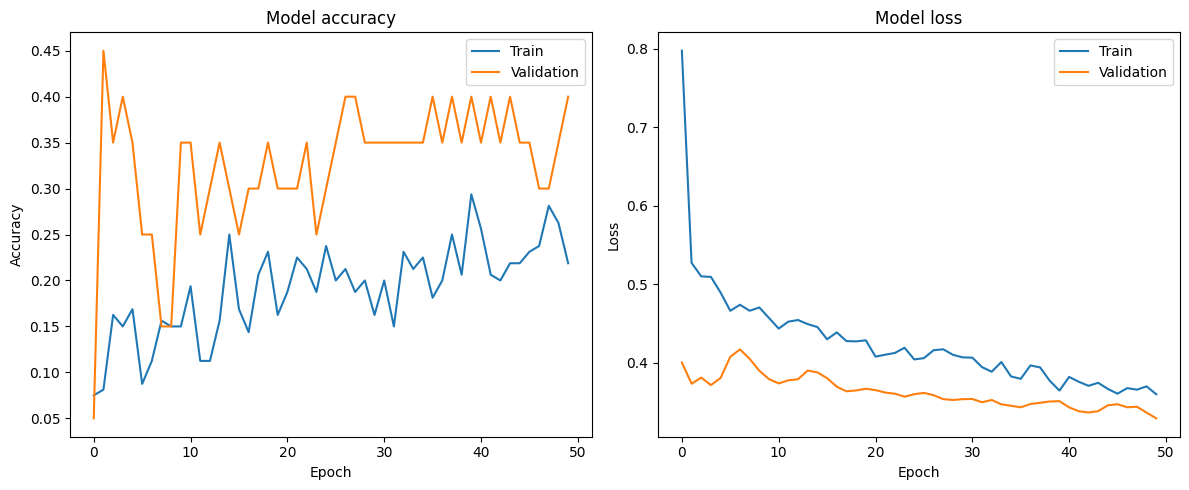

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

## 7) Model Evaluation

In [20]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

1/1 [==============================] - 1s 792ms/step - loss: 0.2920 - accuracy: 0.4500
Test Accuracy: 0.4500


Based on the current architecture both the custom model and the pretrained model peform about the same on 200 images. To improve one or both model is to experiment more with different layers. Parameters and architectures. Also more images could help but this results in a longer training time.